In [8]:
from functions import *
from scripts import *

set_plot_style()

In [6]:
import pandas as pd
import numpy as np

# 1) define a helper to simulate the per-year, per-group totals
def simulate_totals(scenario_factor):
    years  = np.arange(2021, 2026)
    groups = ['MA', 'MM']
    rows = []
    for year in years:
        for g in groups:
            nbi    = 1000 * scenario_factor * (1.0 if g=='MA' else 1.2) * (1 + 0.05*(year-2020))
            varc   =  400 * scenario_factor * (1.0 if g=='MA' else 0.9)
            risk   =  200 * scenario_factor * (1.0 if g=='MA' else 1.1)
            fixc   =  300 * scenario_factor
            rwa    = 2000 * scenario_factor
            rows.append({
                'year': year,
                'groupe': g,
                'total_nbi': nbi,
                'total_variable_costs': varc,
                'total_cost_of_risk': risk,
                'total_fixed_costs': fixc,
                'total_rwa': rwa
            })
    return pd.DataFrame(rows)

# 2) compute RONE from a totals‐DataFrame
def simulate_rone(df_totals):
    df = df_totals.groupby('year').sum().reset_index()
    df['RONE'] = (
        (df['total_nbi']
         - df['total_cost_of_risk']
         + df['total_variable_costs']
         + df['total_fixed_costs'])
        / (df['total_rwa'] * 0.1083)
    )
    return df[['year','RONE']]

# 3) create your three scenarios
test_total_1 = simulate_totals(1.00)
test_total_2 = simulate_totals(1.15)
test_total_3 = simulate_totals(0.85)

test_rone_1  = simulate_rone(test_total_1)
test_rone_2  = simulate_rone(test_total_2)
test_rone_3  = simulate_rone(test_total_3)

import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from IPython.display import Image, display

def plot_nbi_costs_rone_3_scenarios(table_transition_test, dic_matrix):
    def calculate_metrics(table_transition_test, dic_matrix, p, include_new_clients=False):
        # ... your existing metric calculations ...
        return df, df_rone

    
    test_totals, test_rones = [], []

    for p in configurations:
        include_new_clients = (p.annual_new_clients != 0)
        df, df_rone = calculate_metrics(table_transition_test, dic_matrix, p, include_new_clients)
        test_totals.append(df)
        test_rones.append(df_rone)

    test_total_1, test_total_2, test_total_3 = test_totals
    test_rone_1,  test_rone_2,  test_rone_3  = test_rones

    color_map_revenues = {"MA": "#ACE1AF", "MM": "#88AB8E"}
    color_map_costs    = {"MA": "#FFB6C1", "MM": "#FF6347"}
    liste_rone = ["lightgrey", "darkgrey", "grey"]
    liste_decal = [-0.2, 0, 0.2]  # these become the 'offset' values

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    scenarios = [
        ("Scénario 1", "S1", test_total_1, test_rone_1, liste_rone[0], liste_decal[0]),
        ("Scénario 2", "S2", test_total_2, test_rone_2, liste_rone[1], liste_decal[1]),
        ("Scénario 3", "S3", test_total_3, test_rone_3, liste_rone[2], liste_decal[2]),
    ]

    # Add bars for revenues & costs
    for scenario_name, s_name, df, df_rone, color_curve, x_offset in scenarios:
        # aggregate per year & group
        dfg = (
            df.groupby(["year", "groupe"])
              .agg({
                  p.total_nbi: "sum",
                  p.total_variable_costs: "sum",
                  p.total_cost_of_risk: "sum",
                  p.total_fixed_costs: "sum",
                  p.total_rwa: "sum",
                  "count": "sum"
              })
              .reset_index()
        )
        # compute combined costs
        dfg["total_costs"] = (
            dfg[p.total_variable_costs]
            - dfg[p.total_cost_of_risk]
            + dfg[p.total_fixed_costs]
        )

        for group in ["MA", "MM"]:
            dfg_g = dfg[dfg["groupe"] == group]
            rev_col = p.total_nbi
            cost_col = "total_costs"

            # Revenues bar (positive up)
            fig.add_trace(
                go.Bar(
                    x=dfg_g["year"],
                    y=dfg_g[rev_col],
                    name=f"{scenario_name} - Revenus {group}",
                    marker_color=color_map_revenues[group],
                    offset=x_offset,                    # <<–– shifts left/right
                    offsetgroup=f"{s_name}-{group}",   # unique bucket
                    text=s_name,
                    textposition="outside",
                    textfont=dict(color="black", size=10, family="Arial Black"),
                ),
                secondary_y=False,
            )

            # Costs bar (downwards from zero)
            fig.add_trace(
                go.Bar(
                    x=dfg_g["year"],
                    y=-dfg_g[cost_col],
                    name=f"{scenario_name} - Coûts {group}",
                    marker_color=color_map_costs[group],
                    offset=x_offset,
                    offsetgroup=f"{s_name}-{group}",
                    text=s_name,
                    textposition="outside",
                    textfont=dict(color="black", size=10, family="Arial Black"),
                ),
                secondary_y=False,
            )

    # zero-line
    fig.add_trace(
        go.Scatter(
            x=[min(df["year"]) - 1, max(df["year"]) + 1],
            y=[0, 0],
            mode="lines",
            showlegend=False,
            line=dict(color="darkgrey", width=2),
        )
    )

    # RONE curves
    for scenario_name, s_name, df, df_rone, color_curve, x_offset in scenarios:
        fig.add_trace(
            go.Scatter(
                x=df_rone["year"],
                y=df_rone["RONE"],
                name=f"{scenario_name} - RONE (%)",
                mode="lines+text",
                line=dict(color=color_curve, width=4),
                line_shape="spline",
                text=df_rone["RONE"].round(2),
                textfont=dict(family="Arial Black", size=12),
                textposition="bottom center",
            ),
            secondary_y=True,
        )

    # layout tweaks
    fig.update_layout(
        title="Comparaison de 3 scénarios : évolution du PNB, coûts et RONE",
        barmode="relative",
        xaxis_title="Année",
        yaxis_title="Coûts / Revenus (€)",
        template="plotly_white",
        legend_title="Légende",
        margin=dict(l=50, r=50, t=80, b=50),
        legend=dict(orientation="h", yanchor="bottom", xanchor="center", x=0.5),
    )
    fig.update_yaxes(title_text="RONE (%)", secondary_y=True)

    # save & display
    path = "comparaison_metrics"
    fig.write_html(f"{path}.html")
    fig.write_image(f"{path}.png")
    print(f"saved to {path}.png")
    display(Image(filename=f"{path}.png"))
plot_nbi_costs_rone_3_scenarios(table_transition_test=None,  # unused in this dummy run
                                dic_matrix=None)


NameError: name 'configurations' is not defined

In [1]:
import pandas as pd
import numpy as np

# 1) define a helper to simulate the per-year, per-group totals
def simulate_totals(scenario_factor):
    years  = np.arange(2021, 2026)
    groups = ['MA', 'MM']
    rows = []
    for year in years:
        for g in groups:
            nbi    = 1000 * scenario_factor * (1.0 if g=='MA' else 1.2) * (1 + 0.05*(year-2020))
            varc   =  400 * scenario_factor * (1.0 if g=='MA' else 0.9)
            risk   =  200 * scenario_factor * (1.0 if g=='MA' else 1.1)
            fixc   =  300 * scenario_factor
            rwa    = 2000 * scenario_factor
            rows.append({
                'year': year,
                'groupe': g,
                'total_nbi': nbi,
                'total_variable_costs': varc,
                'total_cost_of_risk': risk,
                'total_fixed_costs': fixc,
                'total_rwa': rwa
            })
    return pd.DataFrame(rows)

# 2) compute RONE from a totals‐DataFrame
def simulate_rone(df_totals):
    df = df_totals.groupby('year').sum().reset_index()
    df['RONE'] = (
        (df['total_nbi']
         - df['total_cost_of_risk']
         + df['total_variable_costs']
         + df['total_fixed_costs'])
        / (df['total_rwa'] * 0.1083)
    )
    return df[['year','RONE']]

# 3) create your three scenarios
test_total_1 = simulate_totals(1.00)
test_total_2 = simulate_totals(1.15)
test_total_3 = simulate_totals(0.85)

test_rone_1  = simulate_rone(test_total_1)
test_rone_2  = simulate_rone(test_total_2)
test_rone_3  = simulate_rone(test_total_3)

In [13]:
test_rone_1

,year,RONE
0,2021,7.502308
1,2022,7.756233
2,2023,8.010157
3,2024,8.264081
4,2025,8.518006


In [29]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# helper to darken a hex color
def darken_hex(hex_color, factor=0.8):
    hex_color = hex_color.lstrip('#')
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    r = max(0, min(255, int(r * factor)))
    g = max(0, min(255, int(g * factor)))
    b = max(0, min(255, int(b * factor)))
    return f"#{r:02X}{g:02X}{b:02X}"

# … your simulate_totals and simulate_rone here …

def plot_simulated_scenarios(test_totals, test_rones):
    color_map_revenues = {"MA":"#ACE1AF", "MM":"#88AB8E"}
    palette_rone       = ["lightgrey","darkgrey","grey","black","navy"]

    n       = len(test_totals)
    offsets = np.linspace(-0.3, 0.3, n)

    # 1) make a secondary-y subplot
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # 2) force categorical axis so offsets survive in PNG/HTML
    fig.update_xaxes(type="category")

    # build scenario tuples dynamically
    scenarios = []
    for i, (tot_df, rone_df) in enumerate(zip(test_totals, test_rones)):
        scenarios.append((
            f"Scénario {i+1}", f"S{i+1}",
            tot_df, rone_df,
            palette_rone[i], offsets[i]
        ))

    for scen_name, s_name, df, df_rone, rone_col, x_off in scenarios:
        # aggregate & total_costs
        dfg = df.groupby(["year","groupe"]).sum().reset_index()
        dfg["total_costs"] = (
            dfg["total_variable_costs"]
            - dfg["total_cost_of_risk"]
            + dfg["total_fixed_costs"]
        )

        # Revenus stack MA→MM, only MM gets the label
        for group in ["MA","MM"]:
            sub = dfg[dfg["groupe"]==group]
            fig.add_trace(
                go.Bar(
                    x=sub["year"].astype(str),          # ← cast to string
                    y=sub["total_nbi"],
                    name=f"{scen_name} – Revenus {group}",
                    marker_color=color_map_revenues[group],
                    offset=x_off,
                    offsetgroup=f"{scen_name}-rev",
                    text=(s_name if group=="MM" else None),
                    textposition=("outside" if group=="MM" else None),
                    textfont=dict(family="Arial Black", size=10),
                ),
                secondary_y=False
            )

        # Coûts stack downward, tinted darker
        for group in ["MA","MM"]:
            sub = dfg[dfg["groupe"]==group]
            cost_color = darken_hex(color_map_revenues[group], factor=0.8)
            fig.add_trace(
                go.Bar(
                    x=sub["year"].astype(str),          # ← also categorical
                    y=-sub["total_costs"],
                    name=f"{scen_name} – Coûts {group}",
                    marker_color=cost_color,
                    offset=x_off,
                    offsetgroup=f"{scen_name}-cout"
                ),
                secondary_y=False
            )

        # RONE curve
        fig.add_trace(
            go.Scatter(
                x=df_rone["year"].astype(str),         # keep consistent
                y=df_rone["RONE"],
                name=f"{scen_name} – RONE (%)",
                mode="lines+text",
                line=dict(color=rone_col, width=4),
                line_shape="spline",
                text=df_rone["RONE"].round(2),
                textfont=dict(family="Arial Black", size=12),
                textposition="bottom center"
            ),
            secondary_y=True
        )

    # zero line
    yrs = test_totals[0]["year"].astype(str)
    fig.add_trace(
        go.Scatter(
            x=[yrs.min(), yrs.max()],
            y=[0,0],
            mode="lines",
            showlegend=False,
            line=dict(color="darkgrey", width=2)
        )
    )

    # layout
    fig.update_layout(
        title="Comparaison de scénarios – Évolution du PNB, coûts et RONE",
        barmode="relative",
        xaxis_title="Année",
        yaxis_title="Coûts / Revenus (€)",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", xanchor="center", x=0.5),
        margin=dict(l=50, r=50, t=80, b=50)
    )
    fig.update_yaxes(title_text="RONE (%)", secondary_y=True)

    # export & show
    fig.write_html("comparaison_metrics.html")
    print("Saved to comparaison_metrics.html/.png")

    fig.show()

# then call:
plot_simulated_scenarios(
    [test_total_1, test_total_2, test_total_3],
    [test_rone_1,  test_rone_2,  test_rone_3 ]
)


Saved to comparaison_metrics.html/.png


In [31]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def darken_hex(hex_color: str, factor: float = 0.8) -> str:
    """Return a darker shade of the given hex color."""
    hex_color = hex_color.lstrip('#')
    r, g, b = (int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return '#{:02X}{:02X}{:02X}'.format(
        *(max(0, min(255, int(c * factor))) for c in (r, g, b))
    )

def compute_total_costs(df: pd.DataFrame) -> pd.DataFrame:
    """Group by year/groupe and compute total costs."""
    grouped = df.groupby(['year','groupe'], as_index=False).sum()
    grouped['total_costs'] = (
        grouped['total_variable_costs']
        - grouped['total_cost_of_risk']
        + grouped['total_fixed_costs']
    )
    return grouped

def add_revenue_traces(fig, df_costs, scen_name, s_short, offset, color_map):
    for groupe in ['MA','MM']:
        sub = df_costs[df_costs['groupe'] == groupe]
        fig.add_trace(
            go.Bar(
                x=sub['year'].astype(str),
                y=sub['total_nbi'],
                name=f"{scen_name} – Revenus {groupe}",
                marker_color=color_map[groupe],
                offset=offset,
                offsetgroup=f"{scen_name}-rev",
                text=s_short if groupe=='MM' else None,
                textposition='outside' if groupe=='MM' else None,
                textfont=dict(family='Arial Black', size=10),
            ),
            secondary_y=False
        )

def add_cost_traces(fig, df_costs, scen_name, offset, color_map):
    for groupe in ['MA','MM']:
        sub = df_costs[df_costs['groupe'] == groupe]
        cost_color = darken_hex(color_map[groupe])
        fig.add_trace(
            go.Bar(
                x=sub['year'].astype(str),
                y=-sub['total_costs'],
                name=f"{scen_name} – Coûts {groupe}",
                marker_color=cost_color,
                offset=offset,
                offsetgroup=f"{scen_name}-cout",
            ),
            secondary_y=False
        )

def add_rone_trace(fig, df_rone, scen_name, color, width=4):
    fig.add_trace(
        go.Scatter(
            x=df_rone['year'].astype(str),
            y=df_rone['RONE'],
            name=f"{scen_name} – RONE (%)",
            mode='lines+text',
            line=dict(color=color, width=width),
            line_shape='spline',
            text=df_rone['RONE'].round(2),
            textfont=dict(family='Arial Black', size=12),
            textposition='bottom center'
        ),
        secondary_y=True
    )

def plot_simulated_scenarios(totals_list, rones_list):
    # colour setup
    color_map = {'MA':'#ACE1AF','MM':'#88AB8E'}
    rone_palette = ['lightgrey','darkgrey','grey']  # extend if >3 scenarios

    n = len(totals_list)
    offsets = np.linspace(-0.3, 0.3, n)

    fig = make_subplots(specs=[[{'secondary_y': True}]])
    fig.update_xaxes(type='category')

    for i, (tot_df, rone_df) in enumerate(zip(totals_list, rones_list)):
        scen_name = f"Scénario {i+1}"
        s_short   = f"S{i+1}"
        offs      = offsets[i]
        rcol      = rone_palette[i]

        # prepare aggregated costs
        df_costs = compute_total_costs(tot_df)

        # add stacks and curve
        add_revenue_traces(fig, df_costs, scen_name, s_short, offs, color_map)
        add_cost_traces   (fig, df_costs, scen_name,       offs, color_map)
        add_rone_trace    (fig, rone_df,   scen_name,   rcol)

    # zero line across bars
    years = totals_list[0]['year'].astype(str)
    fig.add_trace(
        go.Scatter(
            x=[years.min(), years.max()],
            y=[0, 0],
            mode='lines',
            line=dict(color='darkgrey', width=2),
            showlegend=False
        ),
        secondary_y=False
    )

    # layout tweaks
    fig.update_layout(
        title="Comparaison de scénarios – Évolution du PNB, coûts et RONE",
        barmode='relative',
        xaxis_title='Année',
        yaxis_title='Coûts / Revenus (€)',
        template='plotly_white',
        legend=dict(orientation='h', x=0.5, xanchor='center', yanchor='bottom'),
        margin=dict(l=50, r=50, t=80, b=50),
    )
    fig.update_yaxes(title_text='RONE (%)', secondary_y=True)

    fig.write_html("comparaison_metrics.html")
    fig.show()

# Usage (unchanged):
plot_simulated_scenarios(
     [test_total_1, test_total_2, test_total_3],
     [test_rone_1,  test_rone_2,  test_rone_3 ]
 )


In [45]:
print(set_plot_style())

None


In [6]:
def set_plot_style():
    import plotly.io as pio
    import seaborn as sns
    import matplotlib.pyplot as plt

    """
    Set the style for matplotlib and plotly plots.
    """
    pio.templates.default = "plotly_white"

    sns.set_theme(style="whitegrid", palette="muted")

    plt.style.use("default")
    plt.rcParams.update(
        {
            "axes.edgecolor": "white",
            "axes.linewidth": 0.8,
            "axes.grid": True,
            "grid.alpha": 0.2,
            "grid.color": "grey",
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.spines.left": False,
            "axes.spines.bottom": False,
            "axes.titlesize": 10,
            "axes.labelsize": 9,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "figure.dpi": 300,
            "savefig.dpi": 300,
            "figure.figsize": (12, 6),
            "xtick.bottom": False,
            "ytick.left": False,
        }
    )

In [7]:
set_plot_style

<function __main__.set_plot_style()>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def darken_hex(hex_color: str, factor: float = 0.8) -> str:
    """Retourne une nuance plus foncée du code hex donné."""
    hex_color = hex_color.lstrip('#')
    r, g, b = (int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    r, g, b = (max(0, min(255, int(c * factor))) for c in (r, g, b))
    return '#{:02X}{:02X}{:02X}'.format(r, g, b)

def compute_total_costs(df: pd.DataFrame) -> pd.DataFrame:
    """Agrège par (year, groupe) et calcule total_costs comme dans Plotly."""
    grp = df.groupby(['year','groupe'], as_index=False).sum()
    grp['total_costs'] = (
        grp['total_variable_costs']
        - grp['total_cost_of_risk']
        + grp['total_fixed_costs']
    )
    return grp

def plot_comparison(totals_list, rones_list):
    # paramètres
    n = len(totals_list)
    years = sorted(totals_list[0]['year'].astype(str).unique())
    x = np.arange(len(years))
    group_width = 0.6
    width = group_width / n
    offsets = np.linspace(-group_width/2 + width/2,
                           group_width/2 - width/2,
                           n)

    color_map   = {'MA': '#ACE1AF', 'MM': '#88AB8E'}
    rone_colors = ['lightgrey','darkgrey','grey']

    # figure & axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    # grille sous les barres
    ax1.set_axisbelow(True)
    ax1.grid(True, zorder=0, color='grey', alpha=0.2)

    # tracé des 3 scénarios
    for i, (tot_df, rone_df) in enumerate(zip(totals_list, rones_list)):
        offs = offsets[i]
        short = f"S{i+1}"
        dfc = compute_total_costs(tot_df)

        # revenus empilés MA puis MM
        rev_ma = dfc.loc[dfc.groupe=='MA','total_nbi'].values
        rev_mm = dfc.loc[dfc.groupe=='MM','total_nbi'].values

        ax1.bar(x+offs, rev_ma, width=width,
                color=color_map['MA'], zorder=3,
                label='Revenus MA')
        ax1.bar(x+offs, rev_mm, width=width,
                bottom=rev_ma,
                color=color_map['MM'], zorder=3,
                label='Revenus MM')

        # annotation S1/S2/S3 au sommet des piles revenus
        for xi, yi in zip(x+offs, rev_ma+rev_mm):
            ax1.text(xi, yi+20, short,
                     ha='center', va='bottom',
                     fontfamily='Arial Black', fontsize=10)

        # coûts empilés négatifs MA puis MM
        cost_ma = -dfc.loc[dfc.groupe=='MA','total_costs'].values
        cost_mm = -dfc.loc[dfc.groupe=='MM','total_costs'].values

        ax1.bar(x+offs, cost_ma, width=width,
                color=darken_hex(color_map['MA']), zorder=3,
                label='Coûts MA')
        ax1.bar(x+offs, cost_mm, width=width,
                bottom=cost_ma,
                color=darken_hex(color_map['MM']), zorder=3,
                label='Coûts MM')

        # courbe RONE sur l'axe secondaire
        rone_vals = rone_df.sort_values('year')['RONE'].values
        ax2.plot(x, rone_vals,
                 linestyle='-', marker='o', linewidth=2,
                 color=rone_colors[i],
                 label='RONE (%)')

        # annotation des valeurs RONE
        for xi, yi in zip(x, rone_vals):
            ax2.text(xi, yi-0.02, f"{yi:.2f}",
                     ha='center', va='top',
                     fontfamily='Arial Black', fontsize=10)

    # ligne zéro pour séparer coûts et revenus
    ax1.axhline(0, color='darkgrey', linewidth=1.5, zorder=2)

    # axes, titre
    ax1.set_xticks(x)
    ax1.set_xticklabels(years)
    ax1.set_xlabel("Année")
    ax1.set_ylabel("Coûts / Revenus (€)")
    ax2.set_ylabel("RONE (%)")
    ax1.set_title("Comparaison de scénarios – Évolution du PNB, coûts et RONE")

    # légende unique (on fusionne et on enlève les doublons)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    all_h = h1 + h2
    all_l = l1 + l2

    uniq = OrderedDict()
    for handle, label in zip(all_h, all_l):
        if label not in uniq:
            uniq[label] = handle

    ax1.legend(uniq.values(), uniq.keys(),
               loc='upper center',
               ncol=5,
               frameon=False)

    plt.tight_layout()
    plt.show()


# Exemple d'appel (en supposant que test_total_1,2,3 et test_rone_1,2,3 sont disponibles) :
plot_comparison(
    [test_total_1, test_total_2, test_total_3],
    [test_rone_1,  test_rone_2,  test_rone_3 ]
)


C:\Users\zetru\AppData\Local\Temp\ipykernel_25492\3629786958.py:42: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
fin

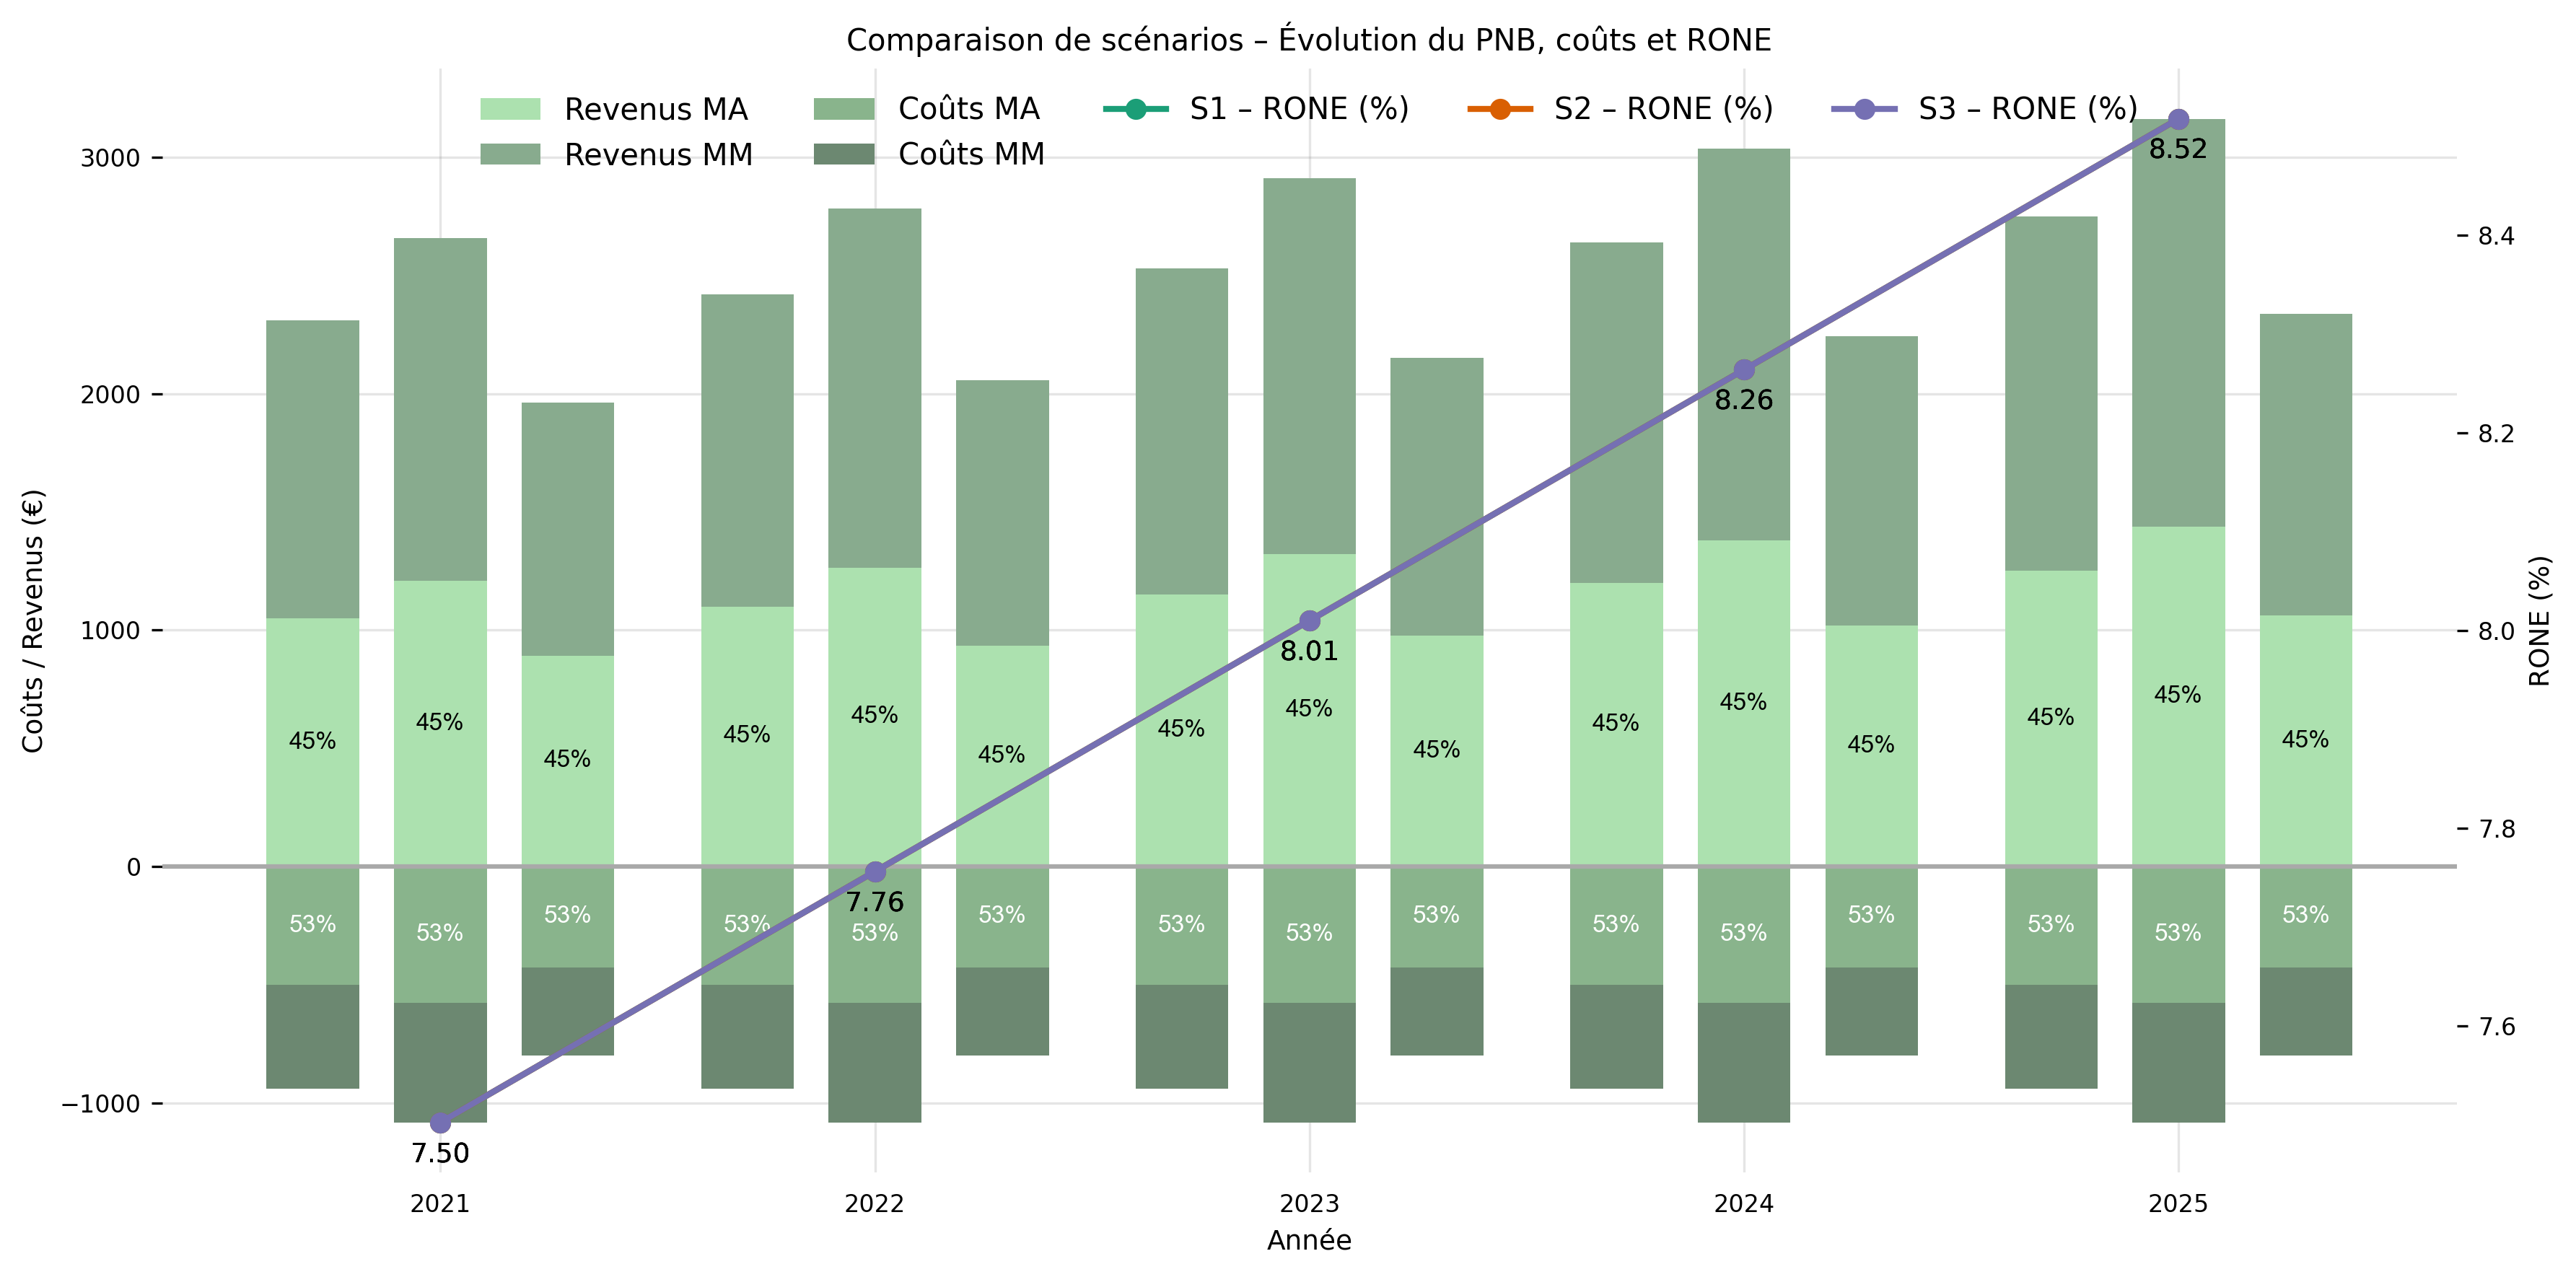

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.cm import get_cmap

def darken_hex(hex_color: str, factor: float = 0.8) -> str:
    h = hex_color.lstrip('#')
    r, g, b = (int(h[i:i+2], 16) for i in (0,2,4))
    r, g, b = (max(0, min(255, int(c * factor))) for c in (r,g,b))
    return '#{:02X}{:02X}{:02X}'.format(r,g,b)

def compute_total_costs(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(['year','groupe'], as_index=False).sum()
    grp['total_costs'] = (
        grp['total_variable_costs']
      - grp['total_cost_of_risk']
      + grp['total_fixed_costs']
    )
    return grp

def plot_comparison(totals_list, rones_list):
    """
    - totals_list: list of df with cols ['year','groupe','total_nbi',
                  'total_variable_costs','total_cost_of_risk','total_fixed_costs']
    - rones_list:  list of df with cols ['year','RONE']
    """
    n     = len(totals_list)
    years = sorted(totals_list[0]['year'].astype(str).unique())
    x     = np.arange(len(years))

    # --- spacing dynamique ---
    group_width = 0.8      # portion de l'unité x par année
    inner_gap   = 0.08     # 8% d'écart entre barres
    bar_width   = (group_width - inner_gap*(n-1)) / n
    offsets     = np.array([
        -group_width/2 + bar_width/2 + i*(bar_width+inner_gap)
        for i in range(n)
    ])

    color_map   = {'MA': '#ACE1AF', 'MM': '#88AB8E'}
    cmap        = get_cmap('Dark2')
    rone_colors = [cmap(i) for i in range(n)]

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    # grille sous les barres
    ax1.set_axisbelow(True)
    ax1.grid(True,  zorder=0, color='grey', alpha=0.2)
    # ax2 au-dessus, transparent, sans grille
    ax1.set_zorder(1)
    ax2.set_zorder(2)
    ax2.patch.set_alpha(0)
    ax2.grid(False)

    for i, (tot_df, rone_df) in enumerate(zip(totals_list, rones_list)):
        offs  = offsets[i]
        label_s = f"S{i+1}"
        dfc   = compute_total_costs(tot_df)

        # --- Revenus MA / MM ---
        rev_ma = dfc.loc[dfc.groupe=='MA','total_nbi'].values
        rev_mm = dfc.loc[dfc.groupe=='MM','total_nbi'].values
        rev_tot = rev_ma + rev_mm
        pct_ma_rev = rev_ma / rev_tot * 100

        ax1.bar(x+offs, rev_ma,
                width=bar_width,
                color=color_map['MA'],
                zorder=2,
                label='Revenus MA')
        ax1.bar(x+offs, rev_mm,
                width=bar_width,
                bottom=rev_ma,
                color=color_map['MM'],
                zorder=2,
                label='Revenus MM')

        # % MA revenus au milieu de la section MA
        for xi, r_ma, pct in zip(x+offs, rev_ma, pct_ma_rev):
            ax1.text(xi, r_ma/2,
                     f"{pct:.0f}%",
                     ha='center', va='center',
                     fontfamily='Arial', fontsize=8,
                     color='black', zorder=3)

        # --- Coûts MA / MM (négatifs) ---
        cost_ma = -dfc.loc[dfc.groupe=='MA','total_costs'].values
        cost_mm = -dfc.loc[dfc.groupe=='MM','total_costs'].values
        cost_tot = - (cost_ma + cost_mm)  # positifs totaux
        pct_ma_cost = (-cost_ma) / cost_tot * 100

        ax1.bar(x+offs, cost_ma,
                width=bar_width,
                color=darken_hex(color_map['MA']),
                zorder=2,
                label='Coûts MA')
        ax1.bar(x+offs, cost_mm,
                width=bar_width,
                bottom=cost_ma,
                color=darken_hex(color_map['MM']),
                zorder=2,
                label='Coûts MM')

        # % MA coûts au milieu de la section MA coût
        for xi, c_ma, pct in zip(x+offs, cost_ma, pct_ma_cost):
            ax1.text(xi, c_ma/2,
                     f"{pct:.0f}%",
                     ha='center', va='center',
                     fontfamily='Arial', fontsize=8,
                     color='white', zorder=3)

        # --- Courbe RONE ---
        rone_vals = rone_df.sort_values('year')['RONE'].values
        ax2.plot(x, rone_vals,
                 linestyle='-',
                 marker='o',
                 linewidth=2,
                 color=rone_colors[i],
                 zorder=4,
                 label=f"S{i+1} – RONE (%)")
        # annotation valeurs RONE
        for xi, yi in zip(x, rone_vals):
            ax2.text(xi, yi-0.02, f"{yi:.2f}",
                     ha='center', va='top',
                     fontfamily='Arial Black', fontsize=9,
                     zorder=5)

    # ligne zéro
    ax1.axhline(0, color='darkgrey', linewidth=1.5, zorder=2)

    # axes & titre
    ax1.set_xticks(x)
    ax1.set_xticklabels(years)
    ax1.set_xlabel("Année")
    ax1.set_ylabel("Coûts / Revenus (€)")
    ax2.set_ylabel("RONE (%)")
    ax1.set_title("Comparaison de scénarios – Évolution du PNB, coûts et RONE")

    # légende unique sans doublons
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    all_h, all_l = h1 + h2, l1 + l2
    uniq = OrderedDict()
    for h, lab in zip(all_h, all_l):
        if lab not in uniq:
            uniq[lab] = h

    ax1.legend(uniq.values(), uniq.keys(),
               loc='upper center', ncol=5, frameon=False)

    plt.tight_layout()
    plt.show()
plot_comparison(
    [test_total_1, test_total_2, test_total_3],
    [test_rone_1,  test_rone_2,  test_rone_3 ]
)

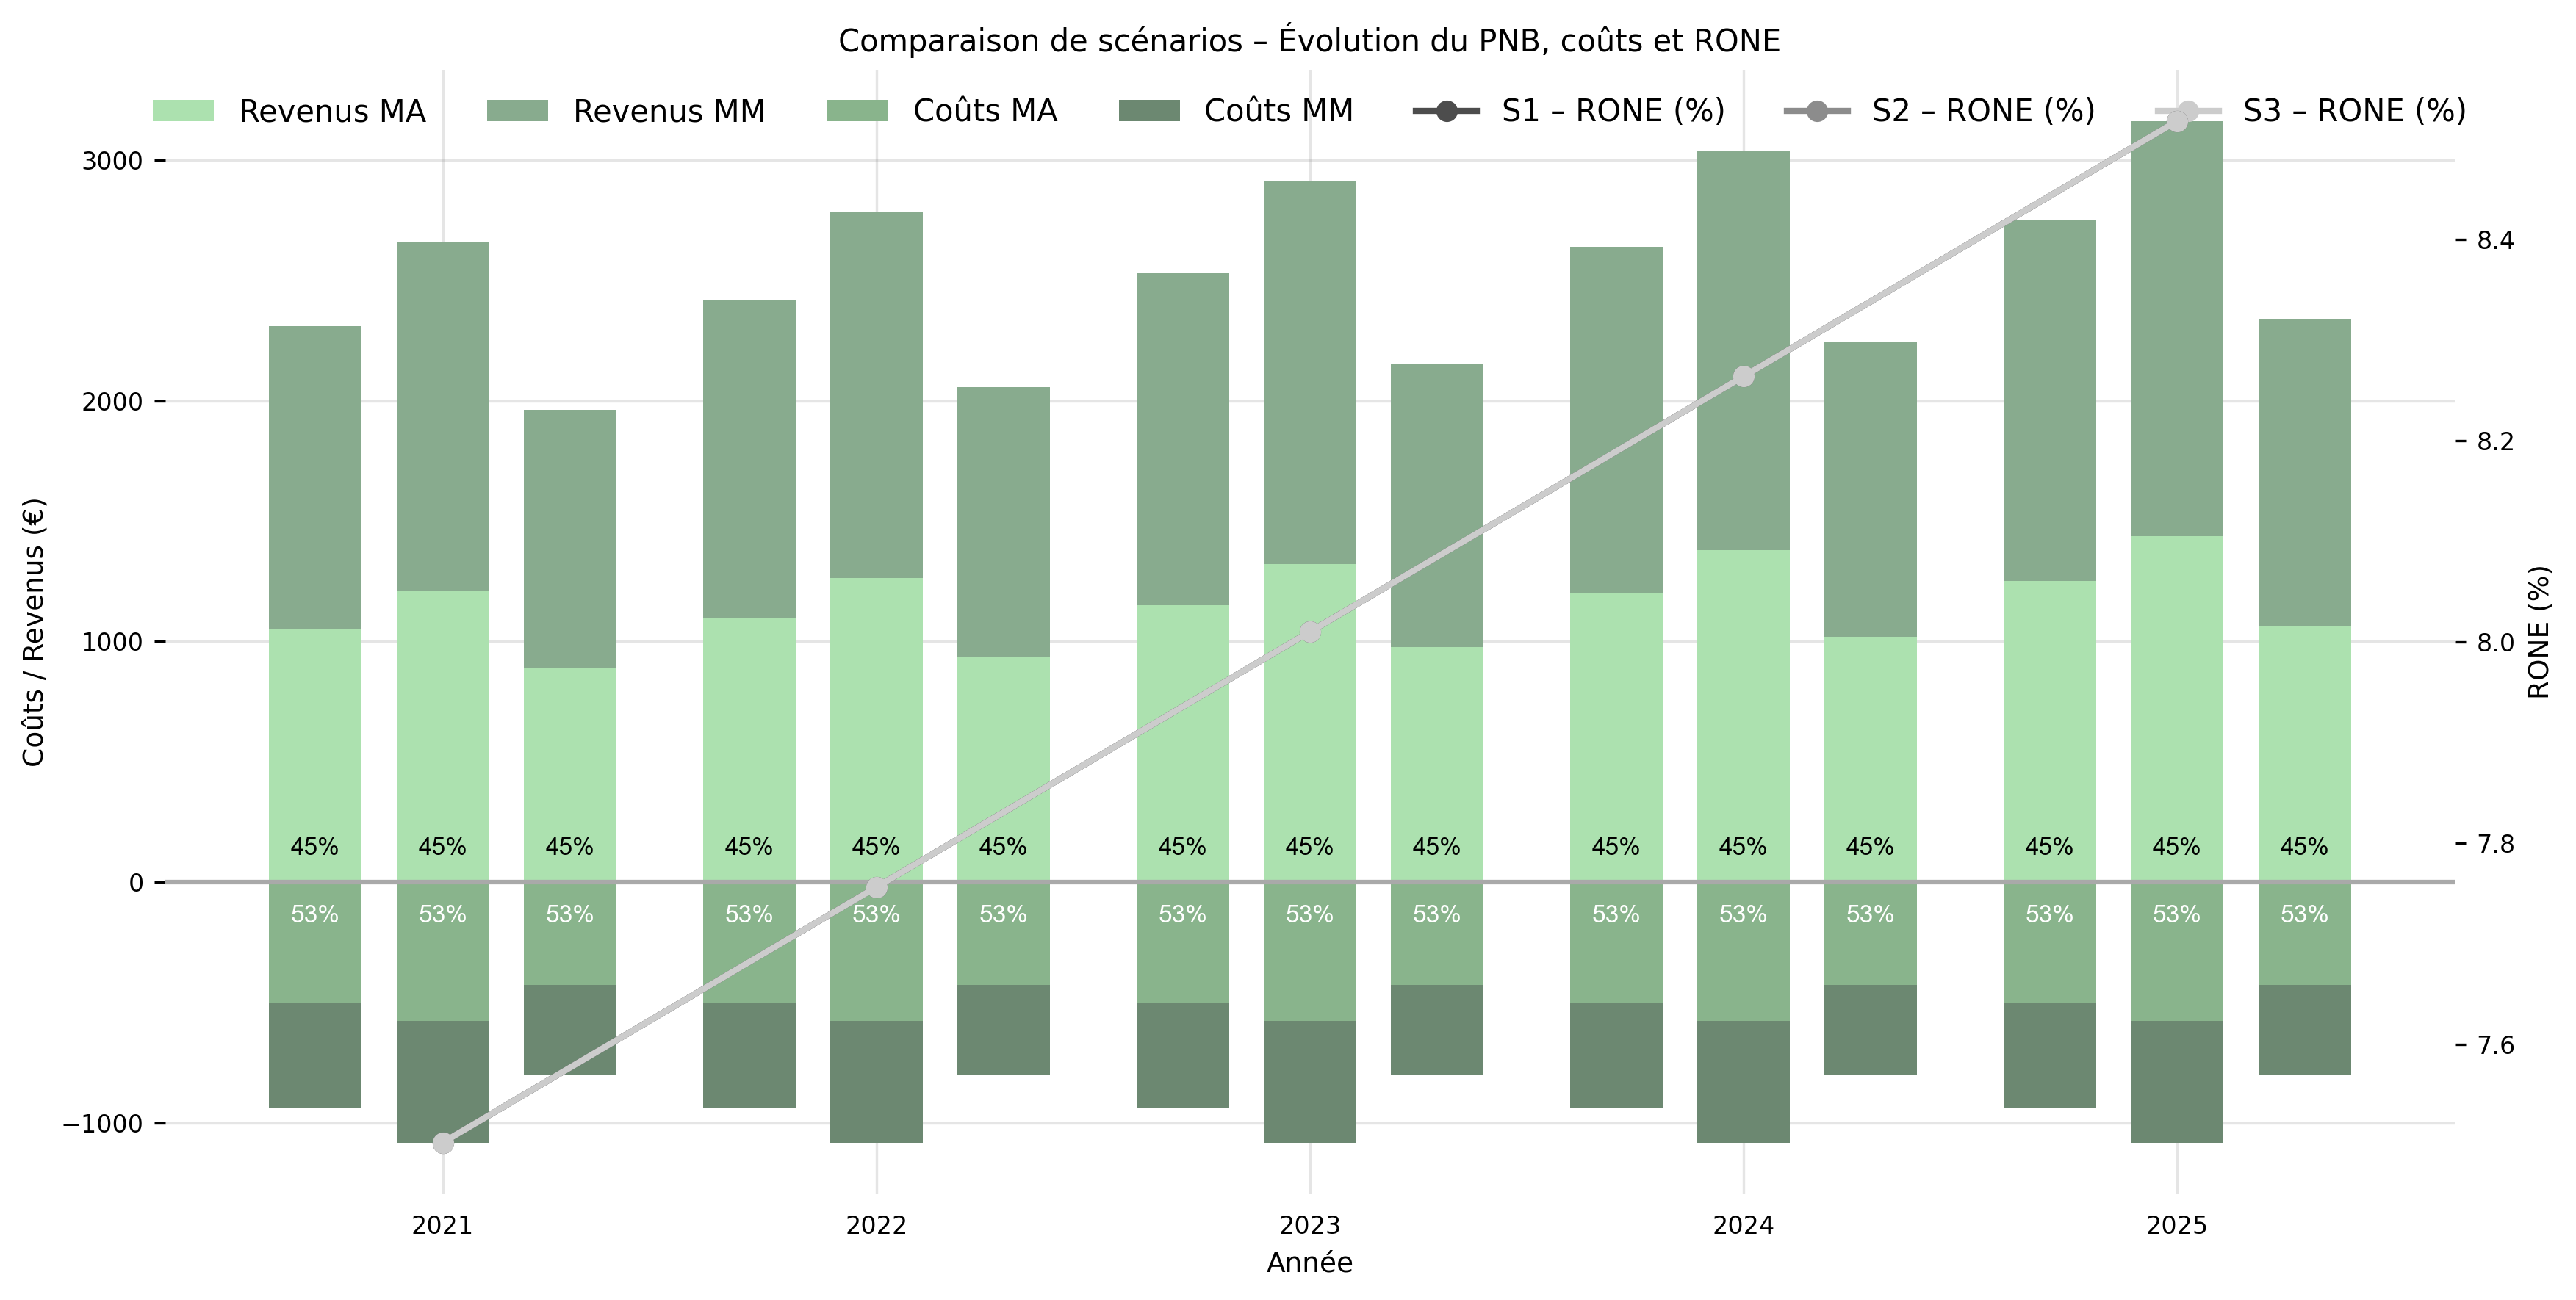

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def darken_hex(hex_color: str, factor: float = 0.8) -> str:
    h = hex_color.lstrip('#')
    r, g, b = (int(h[i:i+2], 16) for i in (0,2,4))
    r, g, b = (max(0, min(255, int(c * factor))) for c in (r,g,b))
    return '#{:02X}{:02X}{:02X}'.format(r,g,b)

def compute_total_costs(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(['year','groupe'], as_index=False).sum()
    grp['total_costs'] = (
        grp['total_variable_costs']
      - grp['total_cost_of_risk']
      + grp['total_fixed_costs']
    )
    return grp

def plot_comparison(totals_list, rones_list):
    # Nombre de scénarios et années
    n     = len(totals_list)
    years = sorted(totals_list[0]['year'].astype(str).unique())
    x     = np.arange(len(years))

    # Espace réservé par année, gap entre barres, calcul des offsets
    group_width = 0.8
    inner_gap   = 0.08
    bar_width   = (group_width - inner_gap*(n-1)) / n
    offsets     = np.array([
        -group_width/2 + bar_width/2 + i*(bar_width+inner_gap)
        for i in range(n)
    ])

    # Couleurs
    color_map   = {'MA': '#ACE1AF','MM': '#88AB8E'}
    # palettes de gris pour RONE
    base_gray   = 0.3
    step_gray   = 0.5 / max(n-1,1)
    rone_colors = [str(base_gray + i*step_gray) for i in range(n)]

    # Figure & axes
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    # grille SOUS les barres
    ax1.set_axisbelow(True)
    ax1.grid(True, zorder=0, color='grey', alpha=0.2)
    # ax2 au-dessus, transparent, sans grille
    ax1.set_zorder(1)
    ax2.set_zorder(2)
    ax2.patch.set_alpha(0)
    ax2.grid(False)

    # 1) Tracé des barres + courbes RONE
    for i, (tot_df, rone_df) in enumerate(zip(totals_list, rones_list)):
        offs = offsets[i]
        scen = f"S{i+1}"
        dfc  = compute_total_costs(tot_df)

        # Revenus MA / MM
        rev_ma = dfc.loc[dfc.groupe=='MA','total_nbi'].values
        rev_mm = dfc.loc[dfc.groupe=='MM','total_nbi'].values

        ax1.bar(x+offs, rev_ma,
                width=bar_width, color=color_map['MA'], zorder=2,
                label='Revenus MA')
        ax1.bar(x+offs, rev_mm,
                width=bar_width, bottom=rev_ma,
                color=color_map['MM'], zorder=2,
                label='Revenus MM')

        # Coûts MA / MM (négatifs)
        cost_ma = -dfc.loc[dfc.groupe=='MA','total_costs'].values
        cost_mm = -dfc.loc[dfc.groupe=='MM','total_costs'].values

        ax1.bar(x+offs, cost_ma,
                width=bar_width,
                color=darken_hex(color_map['MA']), zorder=2,
                label='Coûts MA')
        ax1.bar(x+offs, cost_mm,
                width=bar_width, bottom=cost_ma,
                color=darken_hex(color_map['MM']), zorder=2,
                label='Coûts MM')

        # Courbe RONE
        rone_vals = rone_df.sort_values('year')['RONE'].values
        ax2.plot(x, rone_vals,
                 linestyle='-', marker='o', linewidth=2,
                 color=rone_colors[i], zorder=4,
                 label=f"{scen} – RONE (%)")

    # Ligne zéro
    ax1.axhline(0, color='darkgrey', linewidth=1.5, zorder=3)

    # 2) On attend que Matplotlib ait fixé ses y-limites, pour calculer un pad
    fig.canvas.draw()
    ymin, ymax = ax1.get_ylim()
    pad = (ymax - ymin) * 0.02

    # 3) Second passage : on ajoute les pourcentages MA près de zéro
    for i, tot_df in enumerate(totals_list):
        offs = offsets[i]
        dfc  = compute_total_costs(tot_df)

        # % MA Revenus
        rev_ma = dfc.loc[dfc.groupe=='MA','total_nbi'].values
        rev_mm = dfc.loc[dfc.groupe=='MM','total_nbi'].values
        pct_ma_rev = rev_ma / (rev_ma+rev_mm) * 100
        for xi, pct in zip(x+offs, pct_ma_rev):
            ax1.text(xi, pad,
                     f"{pct:.0f}%",
                     ha='center', va='bottom',
                     fontsize=8, fontfamily='Arial',
                     color='black',
                     zorder=10,
                     clip_on=False)

        # % MA Coûts
        cost_ma = -dfc.loc[dfc.groupe=='MA','total_costs'].values
        cost_mm = -dfc.loc[dfc.groupe=='MM','total_costs'].values
        pct_ma_cost = cost_ma / (cost_ma+cost_mm) * 100
        for xi, pct in zip(x+offs, pct_ma_cost):
            ax1.text(xi, -pad,
                     f"{pct:.0f}%",
                     ha='center', va='top',
                     fontsize=8, fontfamily='Arial',
                     color='white',
                     zorder=10,
                     clip_on=False)

    # Labels & titre
    ax1.set_xticks(x)
    ax1.set_xticklabels(years)
    ax1.set_xlabel("Année")
    ax1.set_ylabel("Coûts / Revenus (€)")
    ax2.set_ylabel("RONE (%)")
    ax1.set_title("Comparaison de scénarios – Évolution du PNB, coûts et RONE")

    # Légende unique (bars + toutes les RONE)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    all_h, all_l = h1 + h2, l1 + l2
    uniq = OrderedDict()
    for h, lab in zip(all_h, all_l):
        if lab not in uniq:
            uniq[lab] = h
    ax1.legend(uniq.values(), uniq.keys(),
               loc='upper center', ncol=len(uniq), frameon=False)

    plt.tight_layout()
    plt.show()
plot_comparison(
    [test_total_1, test_total_2, test_total_3],
    [test_rone_1,  test_rone_2,  test_rone_3 ]
)

In [12]:
test_total_1


,year,groupe,total_nbi,total_variable_costs,total_cost_of_risk,total_fixed_costs,total_rwa
0,2021,MA,1050.0,400.0,200.0,300.0,2000.0
1,2021,MM,1260.0,360.0,220.0,300.0,2000.0
2,2022,MA,1100.0,400.0,200.0,300.0,2000.0
3,2022,MM,1320.0,360.0,220.0,300.0,2000.0
4,2023,MA,1150.0,400.0,200.0,300.0,2000.0
5,2023,MM,1380.0,360.0,220.0,300.0,2000.0
6,2024,MA,1200.0,400.0,200.0,300.0,2000.0
7,2024,MM,1440.0,360.0,220.0,300.0,2000.0
8,2025,MA,1250.0,400.0,200.0,300.0,2000.0
9,2025,MM,1500.0,360.0,220.0,300.0,2000.0


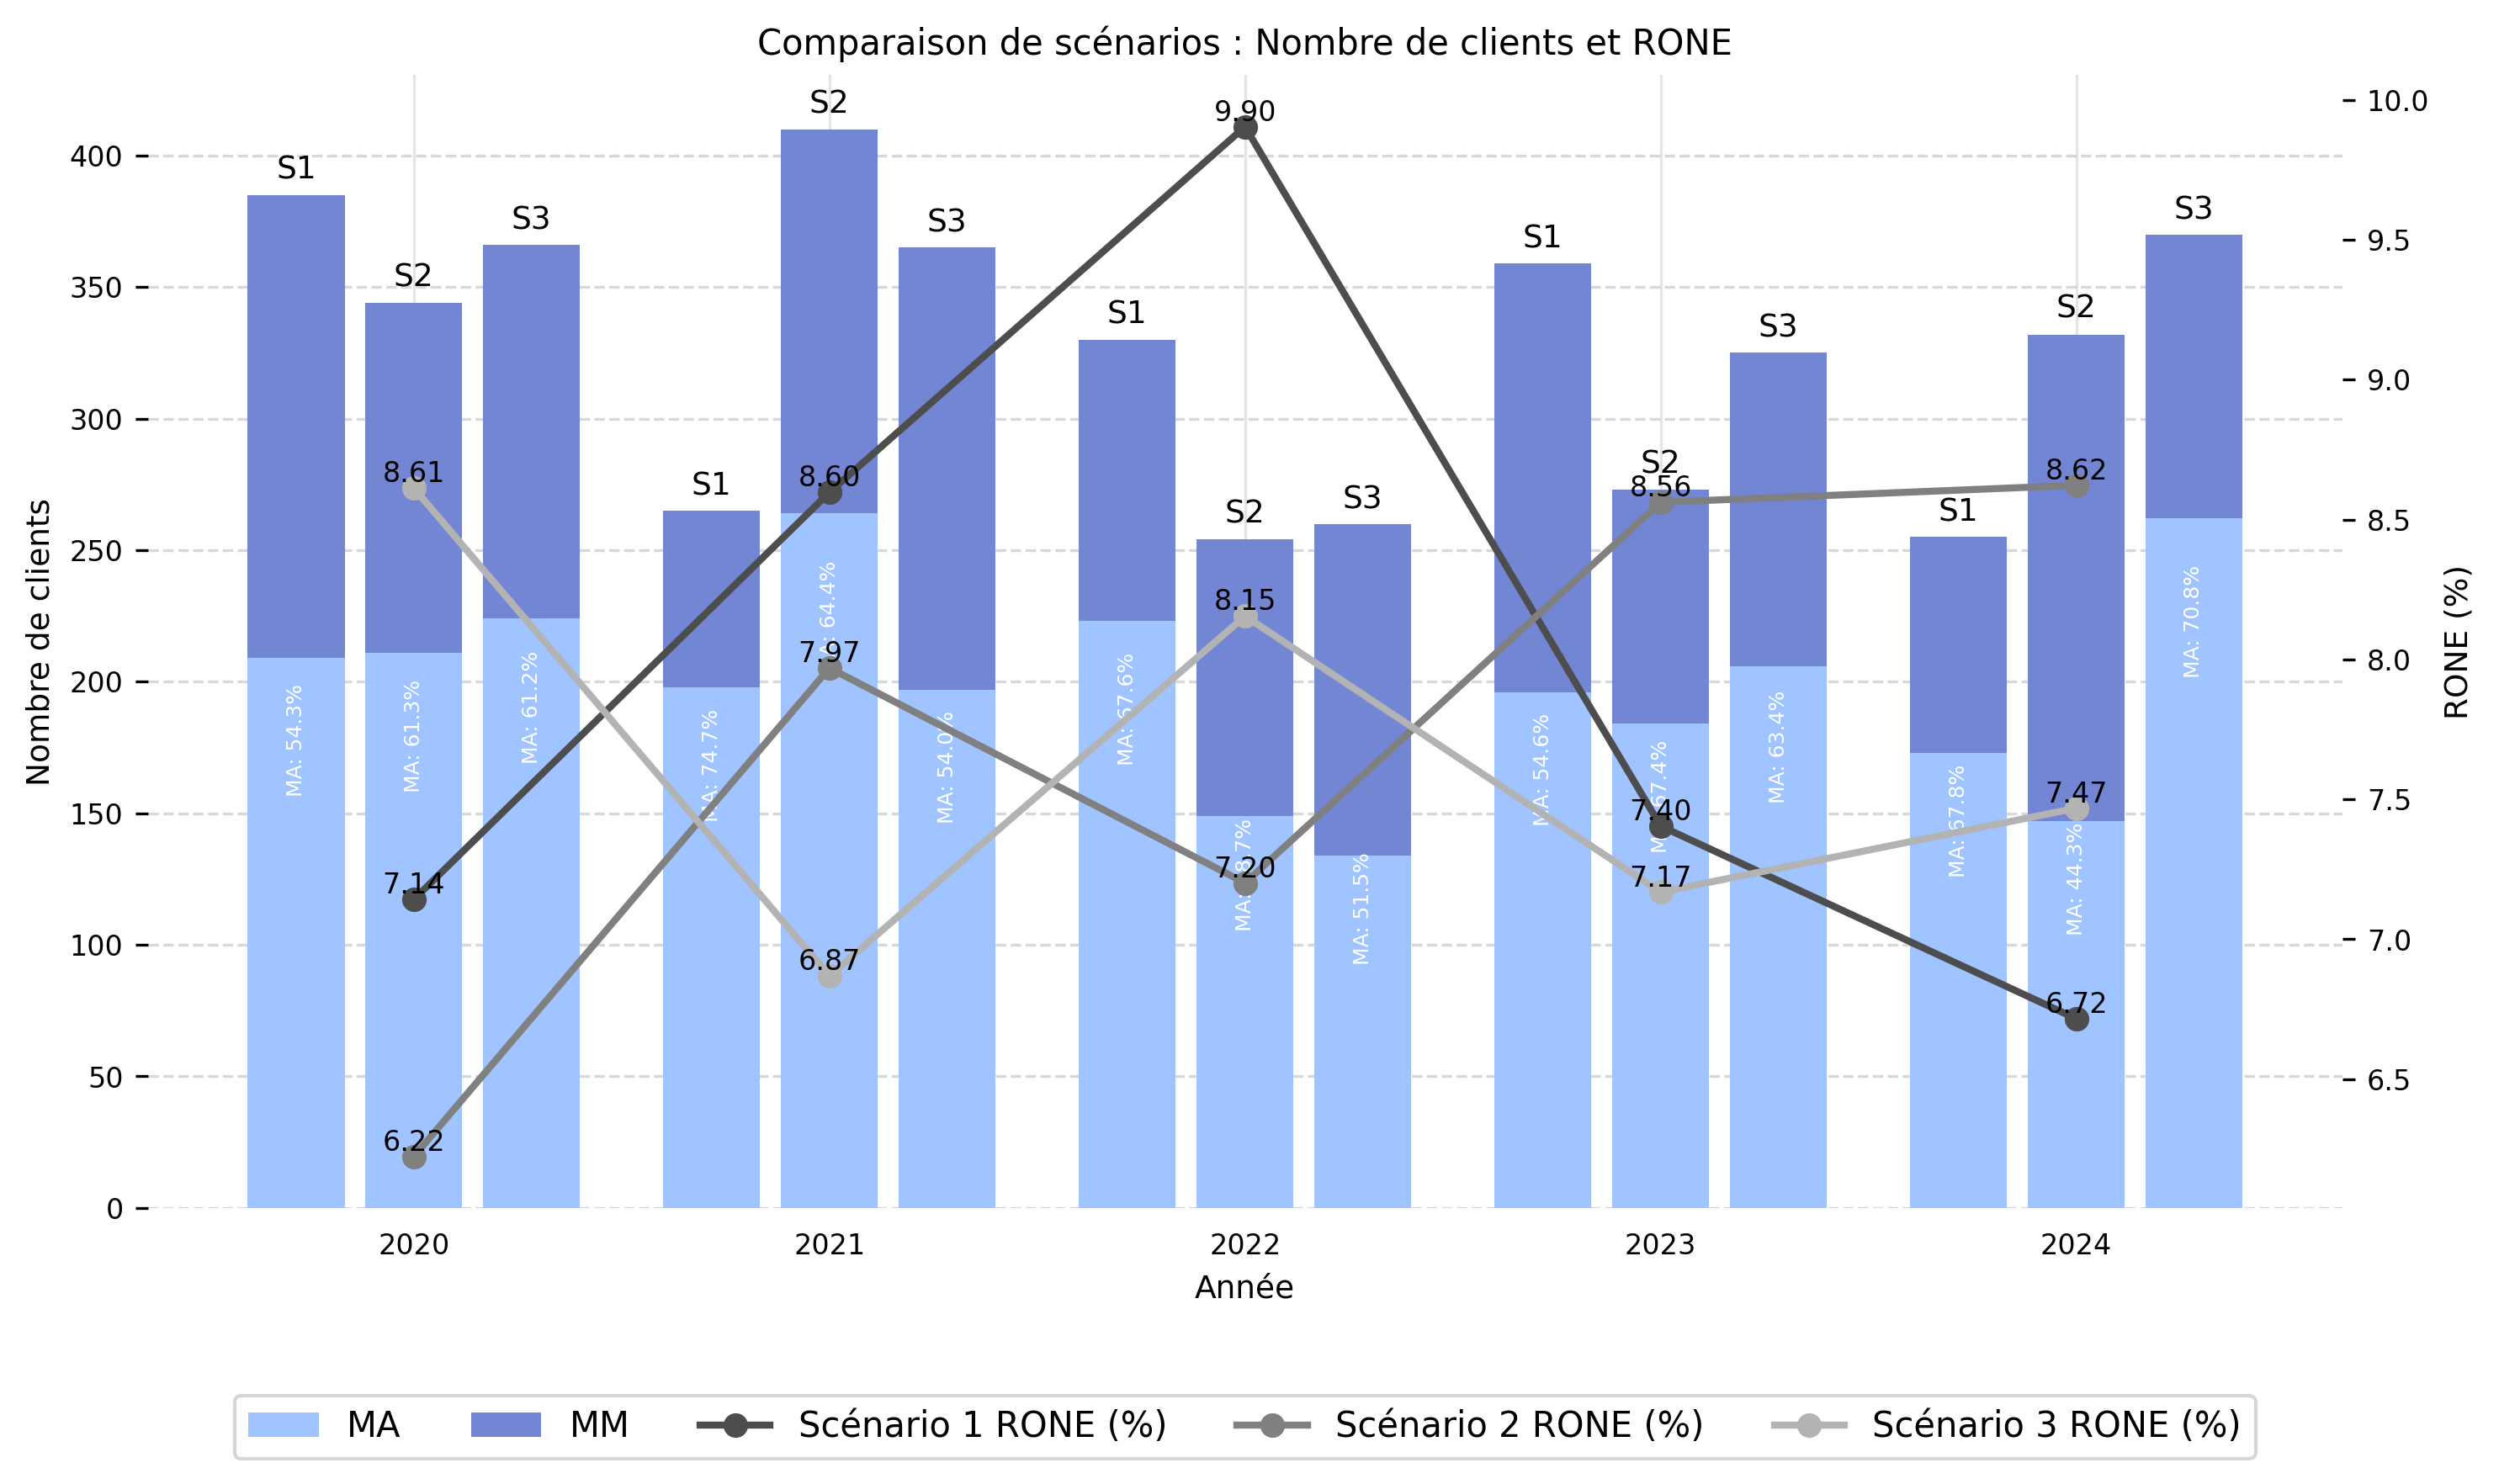

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def plot_clients_rone_scenarios(
    totals_list,
    rones_list,
    scenario_names=None,
    bar_color_map=None,
    gap_frac: float = 0.05
):
    n = len(totals_list)
    years = sorted(totals_list[0]['year'].unique())
    x_idx = np.arange(len(years))

    if scenario_names is None:
        scenario_names = [f"Scénario {i+1}" for i in range(n)]
    if bar_color_map is None:
        bar_color_map = {'MA': '#A0C4FF', 'MM': '#7286D3'}

    # calcul des largeurs et décalages
    group_width = 0.8
    total_gap   = gap_frac * (n - 1)
    bar_width   = (group_width - total_gap) / n
    start = -group_width/2 + bar_width/2
    offsets = [start + i*(bar_width + gap_frac) for i in range(n)]

    fig, ax = plt.subplots(figsize=(10,6))
    ax2 = ax.twinx()

    # grille principale derrière les barres, aucune grille sur l'axe secondaire
    ax.set_axisbelow(True)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax2.grid(False)

    # formatter pour l'axe Y (no sci, entiers)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

    # nuances de gris pour les courbes RONE
    greys = np.linspace(0.3, 0.7, n)
    curve_colors = [(g, g, g) for g in greys]

    for i, (df_tot, df_rone) in enumerate(zip(totals_list, rones_list)):
        name   = scenario_names[i]
        short  = f"S{i+1}"
        offset = offsets[i]
        c_curve = curve_colors[i]

        df = df_tot.copy()
        df['Total'] = df.groupby('year')['count'].transform('sum')
        df['Pct']   = 100 * df['count'] / df['Total']

        piv = df.pivot(index='year', columns='groupe', values=['count','Pct']).fillna(0)
        ct_MA = piv['count']['MA'].reindex(years).values
        ct_MM = piv['count']['MM'].reindex(years).values
        pc_MA = piv['Pct'  ]['MA'].reindex(years).values

        xs = x_idx + offset

        # légendes MA/MM une seule fois
        lab_MA = 'MA' if i == 0 else '_nolegend_'
        lab_MM = 'MM' if i == 0 else '_nolegend_'

        ax.bar(xs, ct_MA, width=bar_width,
               color=bar_color_map['MA'],
               label=lab_MA,
               zorder=2)
        ax.bar(xs, ct_MM, width=bar_width,
               bottom=ct_MA,
               color=bar_color_map['MM'],
               label=lab_MM,
               zorder=2)

        # annotation MA à 90% de la hauteur, vertical
        for x, h_ma, pct in zip(xs, ct_MA, pc_MA):
            ax.text(x, 0.85*h_ma,
                    f"MA: {pct:.1f}%",
                    ha='center', va='center',
                    rotation='vertical',
                    fontsize=6, color='white',
                    zorder=3)

        # label S# au-dessus de la pile
        for x, total_h in zip(xs, ct_MA + ct_MM):
            ax.text(x, total_h + max(ct_MM)*0.02,
                    short,
                    ha='center', va='bottom',
                    fontsize=9, color='black',
                    zorder=3)

        # courbe RONE + annotations en noir
        rone_vals = df_rone.set_index('year').reindex(years)['RONE'].values
        ax2.plot(x_idx, rone_vals,
                 color=c_curve,
                 linewidth=2, marker='o',
                 label=f"{name} RONE (%)",
                 zorder=4)
        for x, y in zip(x_idx, rone_vals):
            ax2.text(x, y, f"{y:.2f}",
                     ha='center', va='bottom',
                     fontsize=8,
                     color='black',      # toujours en noir
                     zorder=5)

    # stylage final
    ax.set_xlabel("Année")
    ax.set_ylabel("Nombre de clients")
    ax2.set_ylabel("RONE (%)")
    ax.set_title("Comparaison de scénarios : Nombre de clients et RONE")
    ax.set_xticks(x_idx)
    ax.set_xticklabels(years)

    # légende combinée
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(
        h1 + h2, l1 + l2,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=n+2
    )

    fig.tight_layout()
    plt.show()


# --------------------------------------------------
# Fake data demo
# --------------------------------------------------
if __name__ == "__main__":
    set_plot_style()
    np.random.seed(123)
    n_scenarios = 3
    years = np.arange(2020, 2025)

    totals_list, rones_list = [], []
    for _ in range(n_scenarios):
        rows, rone_pts = [], []
        for y in years:
            ma, mm = np.random.randint(100,300), np.random.randint(50,200)
            rows.append({'year':y,'groupe':'MA','count':ma})
            rows.append({'year':y,'groupe':'MM','count':mm})
            rone_pts.append({'year':y,'RONE':np.random.uniform(5,10)})
        totals_list.append(pd.DataFrame(rows))
        rones_list .append(pd.DataFrame(rone_pts))

    plot_clients_rone_scenarios(totals_list, rones_list)
